# look down

In [1]:
import networkx

In [2]:
from fa2 import ForceAtlas2

In [1]:
import os
import numpy as np
#import nibabel as nib
import h5py
import time
import sknetwork as skn
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.__version__

'1.17.0'

In [3]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [4]:
brain_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'functional_channel_2_moco_zscore_highpass.h5')
with h5py.File(brain_path, 'r+') as h5_file:
    brain = h5_file.get("data")[:].astype('float32')
brain.shape

(256, 128, 49, 3384)

In [71]:
corr_path = os.path.join(dataset_path, 'fly_143', 'func_0', 'corr', '20220420_corr_dRotLabY.nii')
corr = np.asarray(nib.load(corr_path).get_data().squeeze(), dtype='float32')
corr.shape

NameError: name 'nib' is not defined

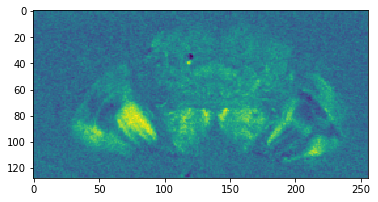

In [23]:
plt.imshow(corr[:,:,20].T)

In [11]:
z=20
neural_activity = brain[:,:,20,:].reshape(-1, 3384)
neural_activity.shape

(32768, 3384)

In [4]:
cluster_dir = os.path.join(dataset_path, 'fly_143', 'func_0', 'clustering')
#os.mkdir(cluster_dir)

In [12]:
n_clusters = 2000
t0 = time.time()

connectivity = grid_to_graph(256,128)
cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
                                memory=cluster_dir,
                                linkage='ward',
                                connectivity=connectivity)
cluster_model.fit(neural_activity)
print('Duration: {}'.format(time.time()-t0))

Duration: 9.055703163146973


/home/users/brezovec/.local/lib/python3.6/site-packages/sklearn/cluster/_hierarchical.py:856: UserWarning: Persisting input arguments took 1.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **kwargs)


In [25]:
cluster_model_labels = cluster_model.labels_

In [13]:
colored = cluster_model.labels_.reshape(256,128).astype('float')
colored.shape

(256, 128)

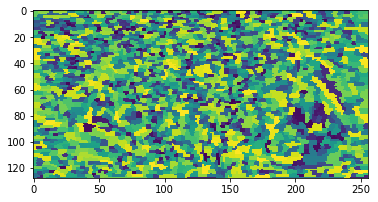

In [17]:
plt.imshow(colored.T)

In [28]:
signals = []
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    mean_signal = np.mean(neural_activity[cluster_indicies,:], axis=0)
    signals.append(mean_signal)
cluster_signals=np.asarray(signals)

In [29]:
cluster_signals.shape

(2000, 3384)

# Network analysis

In [189]:
n_clusters = 2000
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
cluster_dir = os.path.join(dataset_path, 'fly_143', 'func_0', 'clustering')

In [190]:
save_file = os.path.join(cluster_dir, 'slice_20_cluster_signals.npy')
#np.save(save_file, cluster_signals)
cluster_signals = np.load(save_file)

In [191]:
save_file = os.path.join(cluster_dir, 'slice_20_cluster_labels.npy')
#np.save(save_file, cluster_model_labels)
cluster_model_labels = np.load(save_file)

In [3]:
import sknetwork
from sknetwork.clustering import Louvain
from sklearn.covariance import GraphicalLassoCV
from sknetwork.visualization import svg_graph

In [11]:
cluster_signals.shape

(2000, 3384)

In [192]:
corr_matrix = np.corrcoef(cluster_signals)

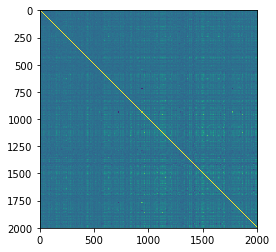

In [28]:
plt.imshow(corr_matrix)

In [193]:
#idk why this but copying from
#https://stackoverflow.com/questions/58384552/how-to-estimate-network-structure-from-weighted-adjacency-matrix-using-sklearn
#probably just to make non-negative and less than 1
corr_matrix = (corr_matrix+1)/2 


In [194]:
np.fill_diagonal(corr_matrix, 0)

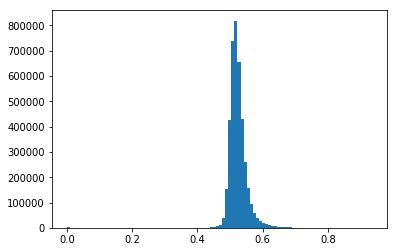

In [195]:
plt.hist(corr_matrix.flatten(),bins=100);

In [256]:
corr_matrix_thresh = np.copy(corr_matrix)
corr_matrix_thresh[np.where(corr_matrix < .55)]=0


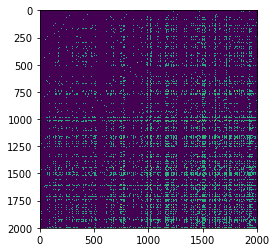

In [257]:
plt.imshow(corr_matrix_thresh)

In [258]:
louvain = Louvain()#modularity = 'potts')

In [259]:
labels = louvain.fit_transform(corr_matrix_thresh)

In [260]:
len(set(labels))

13

In [261]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = labels[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

In [262]:
colored_by_betas.shape

(256, 128)

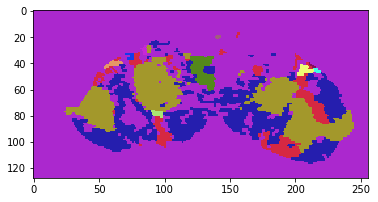

In [263]:
plt.imshow(colored_by_betas.T,cmap=cmap)#,vmin=0,vmax=50)

In [210]:
import matplotlib
cmap = matplotlib.colors.ListedColormap (np.random.rand ( 256,3))

In [161]:
adjacency = sknetwork.utils.edgelist2adjacency(corr_matrix_thresh)

In [163]:
image = svg_graph(adjacency)

In [164]:
image

'<svg width="440" height="340" xmlns="http://www.w3.org/2000/svg">\n<path stroke-width="1.0" stroke="black" d="M 220 170 220 170"/>\n<circle cx="220" cy="170" r="7.0" style="fill:gray;stroke:black;stroke-width:1.0"/>\n</svg>\n'